In [1]:
#loading libraries
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('final_train_data.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head()

comment_text  malignant  \
0  explanation why the edits made under my userna...          0   
1  d aww he matches this background colour i m se...          0   
2  hey man i m really not trying to edit war it s...          0   
3   more i ca not make any real suggestions on im...          0   
4  you sir are my hero any chance you remember wh...          0   

   highly_malignant  rude  threat  abuse  loathe  \
0                 0     0       0      0       0   
1                 0     0       0      0       0   
2                 0     0       0      0       0   
3                 0     0       0      0       0   
4                 0     0       0      0       0   

                                       clean_comment  
0  explanation edits made username hardcore metal...  
1  aww match background colour seemingly stuck th...  
2  hey man really trying edit war guy constantly ...  
3  make real suggestion improvement wondered sect...  
4                      sir hero chance remember page

In [3]:
#removing nan data
data.isnull().sum()

comment_text          0
malignant             0
highly_malignant      0
rude                  0
threat                0
abuse                 0
loathe                0
clean_comment       129
dtype: int64

In [4]:
data.dropna(inplace=True)

# TRAIN TEST SPLIT

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

print(train.shape)
print(test.shape)


(111609, 8)
(47833, 8)


In [6]:
train_text = train['clean_comment']
test_text = test['clean_comment']

**TF-IDF Vectorisation**

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', norm='l2',max_features=1000)
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(max_features=1000, strip_accents='unicode')

In [8]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['comment_text','clean_comment'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['comment_text','clean_comment'], axis=1)

In [9]:
x_train.shape

(111609, 1000)

In [10]:
x_test.shape

(47833, 1000)

# Multi label classification

**Multiple Binary Classifications - (One Vs Rest Classifier)**

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [12]:
categories = data.columns[1:7].values

In [13]:
print(categories)

['malignant' 'highly_malignant' 'rude' 'threat' 'abuse' 'loathe']


In [14]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

**Processing malignant comments...**
Test accuracy is 0.949051909769406


**Processing highly_malignant comments...**
Test accuracy is 0.9904668325214809


**Processing rude comments...**
Test accuracy is 0.9763970480630527


**Processing threat comments...**
Test accuracy is 0.9969059017832876


**Processing abuse comments...**
Test accuracy is 0.9687036146593356


**Processing loathe comments...**
Test accuracy is 0.99216022411306


Wall time: 24.2 s


# Problem Transformation

**Binary Relevance using GaussianNB, MultinomialNB, SVC**

In [15]:
pip install scikit-multilearn

Note: you may need to restart the kernel to use updated packages.


In [16]:
# importing libraries
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,log_loss

In [17]:
def binary_relevance(model):
    
    print("Binary relevance using", model)
    
    classifier = BinaryRelevance(model)
    
    #training
    classifier.fit(x_train,y_train)
    
    #predicting
    prediction = classifier.predict(x_test)
    
    #print performance metrics
    
    print("Accuracy score of the model",accuracy_score(y_test,prediction)*100)
    print('\n')
    try : 
        loss = log_loss(y_test,prediction)
    except :
        loss = log_loss(y_test,prediction.toarray())
    print("Log_loss : {}".format(loss))
    

In [18]:
%%time
binary_relevance(LogisticRegression())

Binary relevance using LogisticRegression()
Accuracy score of the model 91.53722325591119


Log_loss : 1.292286400338191
Wall time: 1min 6s


In [19]:
%%time
binary_relevance(MultinomialNB())

Binary relevance using MultinomialNB()
Accuracy score of the model 91.22781343423996


Log_loss : 1.2734289254761628
Wall time: 5.75 s


In [20]:
%%time
binary_relevance(GaussianNB())

Binary relevance using GaussianNB()
Accuracy score of the model 55.386448686053555


Log_loss : 0.8973104270076475
Wall time: 25.7 s


**Classifier chain**

In [21]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain

def classifier_chain(model):
    
    print("classifier chain using: ", model)
    
    classifier = ClassifierChain(model)
    
    #training
    classifier.fit(x_train,y_train)
    
    #predicting
    prediction = classifier.predict(x_test)
    
    #print performance metrics
    
    print("Accuracy score of the model",accuracy_score(y_test,prediction)*100)
    print('\n')
    try : 
        loss = log_loss(y_test,prediction)
    except :
        loss = log_loss(y_test,prediction.toarray())
    print("Log_loss : {}".format(loss))
    

In [22]:
classifier_chain(GaussianNB())

classifier chain using:  GaussianNB()
Accuracy score of the model 58.64361424121422


Log_loss : 0.814404564375495


In [23]:
classifier_chain(MultinomialNB())

classifier chain using:  MultinomialNB()
Accuracy score of the model 89.91282169213723


Log_loss : 0.5036413884935494


In [24]:
classifier_chain(LogisticRegression())

classifier chain using:  LogisticRegression()


C:\Users\Rahul\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score of the model 91.60621328371626


Log_loss : 1.0803856359573452


**Label Power set**

In [25]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset

def label_power(model):
    
    print("label power set  using: ", model)
    
    classifier = LabelPowerset(model)
    
    #training
    classifier.fit(x_train,y_train)
    
    #predicting
    prediction = classifier.predict(x_test)
    
    #print performance metrics
    
    print("Accuracy score of the model",accuracy_score(y_test,prediction)*100)
    print('\n')
    try : 
        loss = log_loss(y_test,prediction)
    except :
        loss = log_loss(y_test,prediction.toarray())
    print("Log_loss : {}".format(loss))

In [26]:
label_power(GaussianNB())

label power set  using:  GaussianNB()
Accuracy score of the model 27.290782514163865


Log_loss : 2.4795338717519773


In [27]:
label_power(MultinomialNB())

label power set  using:  MultinomialNB()
Accuracy score of the model 91.05429306127569


Log_loss : 0.8398879894527442


In [28]:
label_power(LogisticRegression())

label power set  using:  LogisticRegression()


C:\Users\Rahul\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score of the model 91.58530721468442


Log_loss : 1.153452633927969


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import itertools

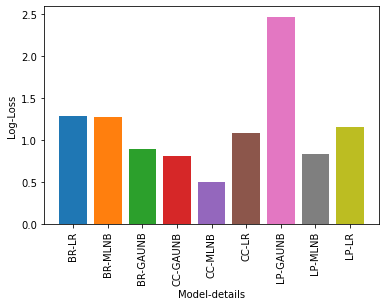

In [30]:
x = ['BR-LR','BR-MLNB','BR-GAUNB','CC-GAUNB','CC-MLNB','CC-LR','LP-GAUNB','LP-MLNB','LP-LR']
y = [1.29,1.27,0.89,0.81,0.50,1.08,2.47,0.83,1.15]
plt.ylabel('Log-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i])
plt.show()

**Here we can see that using classifier chain with multinomialNB we are getting minimum log-loss**